In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import time
from scipy import stats

In [3]:
def show_graph(adj_matrix, clique):
    graph = nx.from_numpy_matrix(adj_matrix)
    subgraph = graph.subgraph(clique)
    nx.draw(subgraph, with_labels=True)
    plt.axis('equal')
    
def import_graph(filepath):
    graph = None
    f = open(filepath, 'r')
    lines = f.readlines()
    for i in lines:
        line = i.strip('\n').split(' ')
        if line[0] == 'p':
            graph = np.zeros((int(line[2]), int(line[2])), dtype = int)
        elif line[0] == 'e':
            graph[int(line[1])-1][int(line[2])-1] = 1
            
    return graph
        


In [16]:
def initialize_population(adj_matrix, pop_size):
    population = []
    
    for i in range(0, pop_size):
        individual = []
        random_node = pick_node(adj_matrix)
        neighbors = get_neighbors(random_node, adj_matrix)
        individual.append(random_node)
        random.shuffle(neighbors)
        
        individual = find_clique(neighbors, random_node, adj_matrix)
        population.append(individual)
    return population

def get_neighbors(node, adj_matrix):
    connections = adj_matrix[node-1]
    
    neighbors = []
    for i in range(0, len(connections)):
        if connections[i] == 1:
            neighbors.append(i+1)
    
    return neighbors

def pick_node(adj_matrix):
    return random.randrange(len(adj_matrix))

def find_clique(node_list, point, adj_matrix):
    '''
    clique = [point]
    for i in node_list:
        if fully_connected(clique, i, adj_matrix):
            clique.append(i)
    '''
    clique = [point]
    for i in node_list:
        connected = True
        for j in clique:
            if adj_matrix[i-1][j-1] == 0:
                connected = False
        if connected:
            clique.append(i)
    
    
    return clique

def improve_clique(clique, chromosome, adj_matrix):
    new_clique = clique
    idx = random.randrange(len(chromosome))
    for i in range(idx-1, len(chromosome)):
        if i not in new_clique and fully_connected(new_clique, i, adj_matrix):
            new_clique.append(i)
    return new_clique
    
def fully_connected(node_list, adj_matrix):
    graph = nx.from_numpy_matrix(adj_matrix)
    connected = True
    for i in node_list:
        for j in node_list:
            if i != j:
                if not graph.has_edge(i, j):
                    connected = False
                    print("Nodes " + str(i) + " and " + str(j) + " are not connected")
    return connected

def rank_pop_elite(population, gen_size):
    fitness_scores = []
    
    for i in population:
        fitness_scores.append(len(i))  
        
    scored = zip(population, fitness_scores)
    sorted_pop = sorted(scored, key=lambda x: x[1], reverse=True)
    to_breed = []
    for i in sorted_pop[:gen_size]:
        to_breed.append(i[0])
        
    return to_breed

def breed(parent1, parent2, adj_matrix):
    #Get random point in p1 and p2
    p1_node = pick_node(parent1)
    p2_node = pick_node(parent2)
    
    #Get random subgraph of p1 neighbors and random subgraph of p2 neighbors
    p1_neighbors = get_neighbors(p1_node, adj_matrix)
    p2_neighbors = get_neighbors(p2_node, adj_matrix)
    
    #Combine subgraphs
    gene1 = int(random.random()*len(p1_neighbors))
    gene2 = int(random.random() *len(p1_neighbors))
    
    start_idx = min(gene1, gene2)
    end_idx = max(gene1, gene2)
    
    subgraph1 = p1_neighbors[start_idx:end_idx]
    subgraph2 = [i for i in p2_neighbors if i not in subgraph1]
    
    candidate_child = subgraph1+subgraph2
    
    #Get random point in child
    child_point = pick_node(candidate_child)
    
    #Find clique involving child point
    child = find_clique(candidate_child, child_point, adj_matrix)
    child = improve_clique(child, candidate_child, adj_matrix)
    
    #Return child clique
    return child

def breed_pop(pool, size, adj_matrix):
    children = []
    
    for i in pool:
        children.append(i)
        
    while len(children) < size:
        parents = random.sample(pool, 2)
        child = breed(parents[0], parents[1], adj_matrix)
        children.append(child)
    return children

#TODO: Implement Mutation
def mutate(individual, adj_matrix):
    random_node = pick_node(individual)
    #neighbors = get_neighbors(random_node, adj_matrix)
    individual[random_node-1] = random.randrange(len(adj_matrix))
    clique = find_clique(individual, random_node, adj_matrix)
    
    return clique

def mutate_population(population, mut_rate, adj_matrix):
    new_pop = []
    for i in population:
        chance = random.random()
        if chance <= mut_rate:
            new_pop.append(mutate(i, adj_matrix))
        else:
            new_pop.append(i)
    return new_pop
            
def make_generation(curr_gen, pop_size, pool_size, mut_rate, adj_matrix):
    pop_to_breed = rank_pop_elite(curr_gen, pool_size)
    new_generation = breed_pop(pop_to_breed, pop_size, adj_matrix)
    new_generation = mutate_population(new_generation, mut_rate, adj_matrix)
    return new_generation

def find_fitnesses(generation):
    fitness = []
    for i in generation:
        fitness.append(len(i))
    return fitness

def run_ga_clique(adj_matrix, num_generations, pop_size, pool_size, mut_rate):
    start_time = time.time()
    
    best_gen_fit_list = []
    gen_cliques = []
    
    pop = initialize_population(adj_matrix, pop_size)
    
    for i in range(0, num_generations):
        if (i+1)%25 == 0:
            print("Generation: " + str(i+1))
        next_generation = make_generation(pop, pop_size, pool_size, mut_rate, adj_matrix)
        fitnesses = find_fitnesses(next_generation)
        
        best_gen_fit = 0
        best_gen_clique = None
        
        for j in next_generation:
            if len(j) > best_gen_fit:
                best_gen_fit = len(j)
                best_gen_clique = j
         
        best_gen_fit_list.append(best_gen_fit)
        gen_cliques.append(best_gen_clique)
        
    
    return (best_gen_fit_list, gen_cliques)

def get_degrees(clique, adj_matrix):
    degrees = []
    for i in clique:
        count = 0
        for j in clique:
            if adj_matrix[i-1][j-1] == 1:
                count +=1
        degrees.append((i, count))
    return degrees

Running GA 0...
Generation: 25
Generation: 50
Generation: 75
Generation: 100
Generation: 125
Generation: 150
Generation: 175
Generation: 200
Largest Clique Size: 
13
Largest Clique: 
[14, 60, 62, 63, 65, 72, 88, 95, 117, 132, 138, 151, 165]
Clique Size Statistics: 
DescribeResult(nobs=201, minmax=(11, 13), mean=12.08955223880597, variance=0.21194029850746268, skewness=0.3322691265255208, kurtosis=1.4334313628248383)
Time Statistics: 
DescribeResult(nobs=1, minmax=(29.285878658294678, 29.285878658294678), mean=29.285878658294678, variance=nan, skewness=0.0, kurtosis=-3.0)


c:\users\rsc\appdata\local\continuum\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
c:\users\rsc\appdata\local\continuum\miniconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


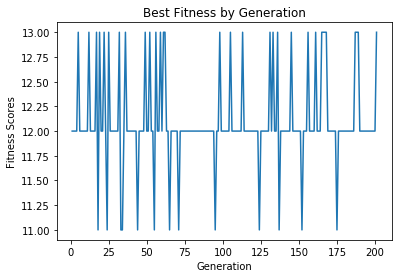

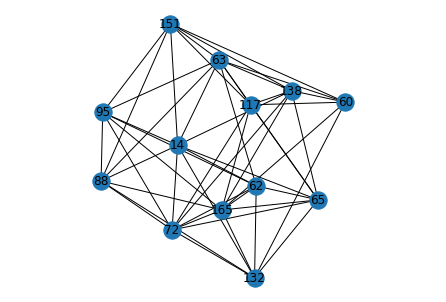

In [5]:
adj_matrix = import_graph('DIMACS_all_ascii/brock200_4.clq')


fits = []
times = []
best_fit = 0
best_clique = None
all_cliques = []

#Run ga algorithm 15 times
for i in range(0,1):
    start_time = time.time()
    print("Running GA " + str(i) + "...")
    fits, cliques = run_ga_clique(adj_matrix, 200, 200, 5, 0.1)
    run_time = time.time()-start_time
    
    max_fit = max(fits)
    max_fit_idx = fits.index(max(fits))
    clique = cliques[max_fit_idx]
    
    times.append(run_time)
    all_cliques.append(clique)
    fits.append(max_fit)
    if max_fit > best_fit:
        best_fit = max_fit
        best_clique = clique
        
#Print results
print("Largest Clique Size: ")
print(best_fit)
print("Largest Clique: ")
print(best_clique)
print("Clique Size Statistics: ")
print(stats.describe(fits))
print("Time Statistics: ")
print(stats.describe(times))

plt.plot(range(1, len(fits)+1), fits)
plt.title("Best Fitness by Generation")
plt.xlabel("Generation")
plt.ylabel("Fitness Scores")
plt.show()

show_graph(adj_matrix, best_clique)

In [19]:
graph = nx.from_numpy_matrix(adj_matrix)
subgraph = graph.subgraph(best_clique).copy()
print(best_clique)
print(find_clique(best_clique, best_clique[0], adj_matrix))
list(subgraph.degree(list(subgraph.nodes)))
print(adj_matrix[14, 60])
print(fully_connected(best_clique, adj_matrix))
print(graph.has_edge(88, 65))

[14, 60, 62, 63, 65, 72, 88, 95, 117, 132, 138, 151, 165]
[14, 60, 62, 63, 65, 72, 88, 95, 117, 132, 138, 151, 165]
0
Nodes 14 and 60 are not connected
Nodes 14 and 117 are not connected
Nodes 14 and 165 are not connected
Nodes 60 and 14 are not connected
Nodes 60 and 62 are not connected
Nodes 60 and 65 are not connected
Nodes 60 and 72 are not connected
Nodes 60 and 88 are not connected
Nodes 60 and 95 are not connected
Nodes 62 and 60 are not connected
Nodes 62 and 88 are not connected
Nodes 62 and 117 are not connected
Nodes 62 and 138 are not connected
Nodes 62 and 151 are not connected
Nodes 63 and 72 are not connected
Nodes 63 and 132 are not connected
Nodes 63 and 165 are not connected
Nodes 65 and 60 are not connected
Nodes 65 and 88 are not connected
Nodes 65 and 95 are not connected
Nodes 65 and 151 are not connected
Nodes 72 and 60 are not connected
Nodes 72 and 63 are not connected
Nodes 72 and 151 are not connected
Nodes 88 and 60 are not connected
Nodes 88 and 62 are not